Kiểu dữ liệu của exog_train:
 oil_price     float64
gold_price    float64
dtype: object
Kiểu dữ liệu của exog_test:
 oil_price     float64
gold_price    float64
dtype: object


06:15:14 - cmdstanpy - INFO - Chain [1] start processing
06:15:15 - cmdstanpy - INFO - Chain [1] done processing
06:15:15 - cmdstanpy - INFO - Chain [1] start processing
06:15:15 - cmdstanpy - INFO - Chain [1] done processing



RMSE Results:
Exponential Smoothing CPI MoM: 0.2461
Exponential Smoothing CPI YoY: 1.1998
SARIMA CPI MoM: 0.1900
SARIMA CPI YoY: 0.2592
Auto-SARIMA CPI MoM: 0.3599
Auto-SARIMA CPI YoY: 0.2111
SARIMAX CPI MoM: 0.2165
SARIMAX CPI YoY: 0.2677
Auto-SARIMAX CPI MoM: 0.3599
Auto-SARIMAX CPI YoY: 0.2111
Prophet CPI MoM: 0.2702
Prophet CPI YoY: 2.0459

MAE Results:
Exponential Smoothing CPI MoM: 0.2036
Exponential Smoothing CPI YoY: 0.8875
SARIMA CPI MoM: 0.1733
SARIMA CPI YoY: 0.2136
Auto-SARIMA CPI MoM: 0.2944
Auto-SARIMA CPI YoY: 0.1719
SARIMAX CPI MoM: 0.1805
SARIMAX CPI YoY: 0.2142
Auto-SARIMAX CPI MoM: 0.2944
Auto-SARIMAX CPI YoY: 0.1719
Prophet CPI MoM: 0.2323
Prophet CPI YoY: 1.5334

MAPE Results:
Exponential Smoothing CPI MoM: 0.2032
Exponential Smoothing CPI YoY: 0.8608
SARIMA CPI MoM: 0.1728
SARIMA CPI YoY: 0.2067
Auto-SARIMA CPI MoM: 0.2937
Auto-SARIMA CPI YoY: 0.1655
SARIMAX CPI MoM: 0.1801
SARIMAX CPI YoY: 0.2074
Auto-SARIMAX CPI MoM: 0.2937
Auto-SARIMAX CPI YoY: 0.1655
Prophet 

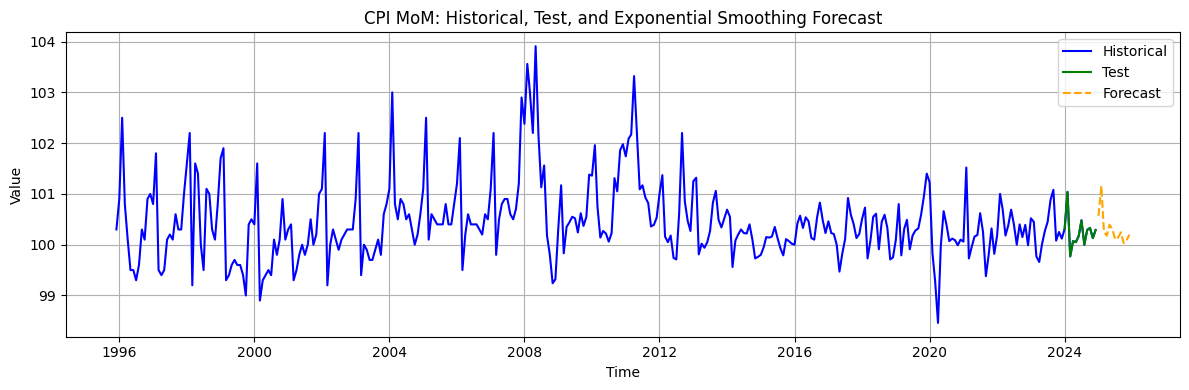

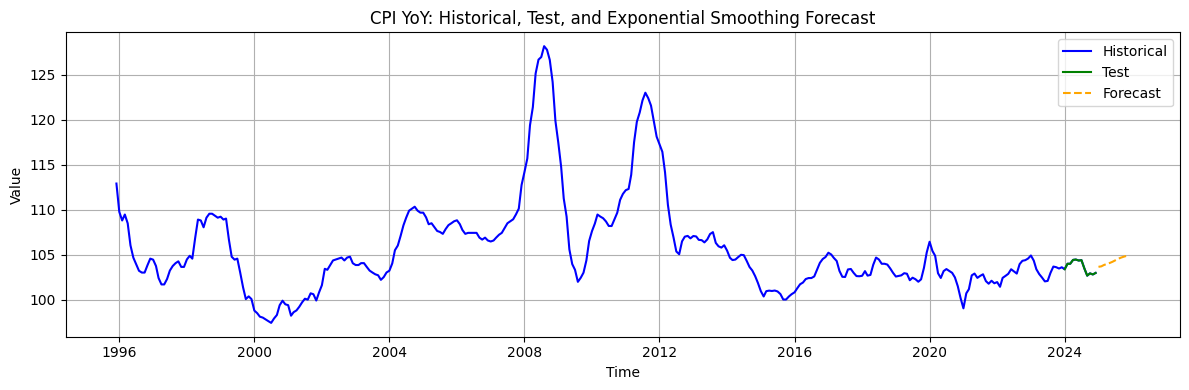

<Figure size 500x300 with 0 Axes>

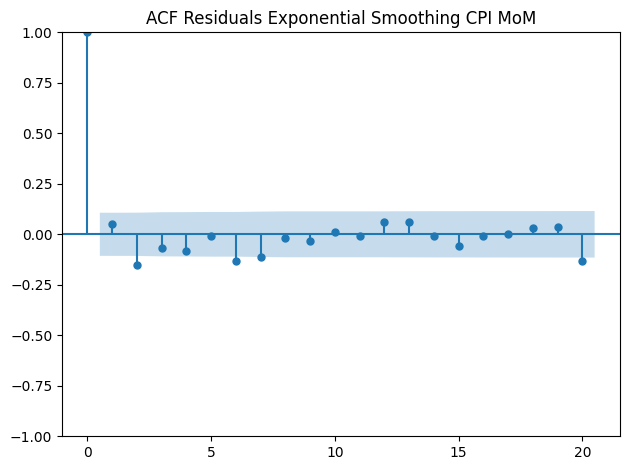

<Figure size 500x300 with 0 Axes>

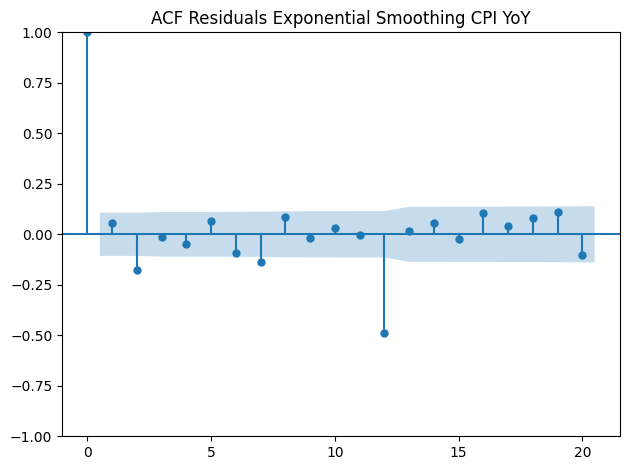

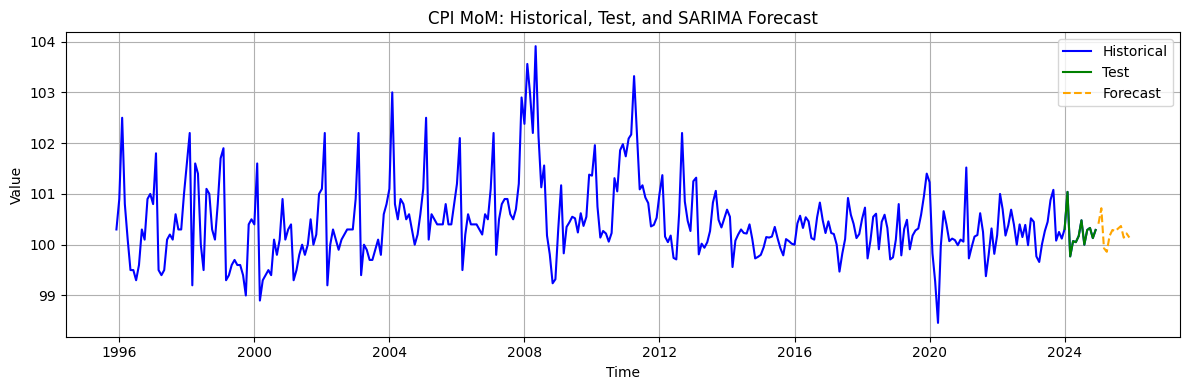

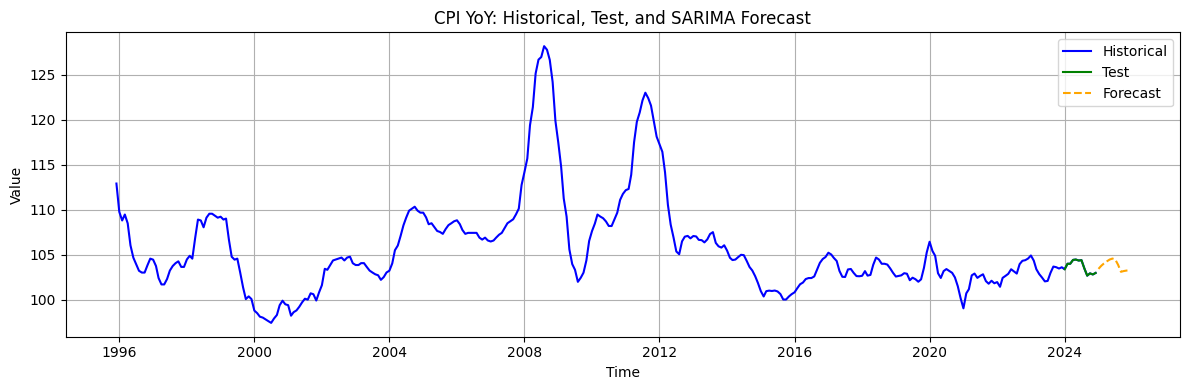

<Figure size 500x300 with 0 Axes>

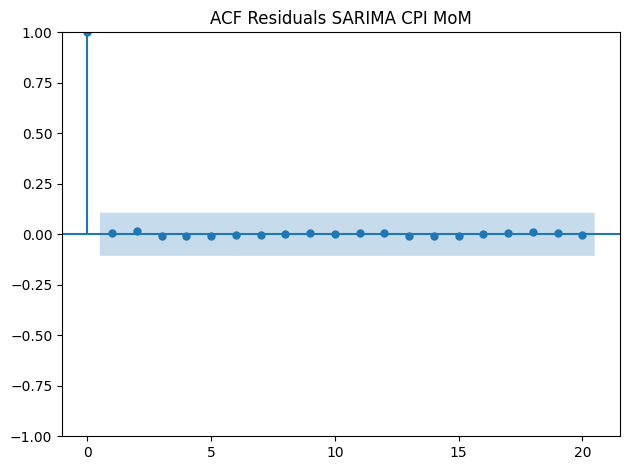

<Figure size 500x300 with 0 Axes>

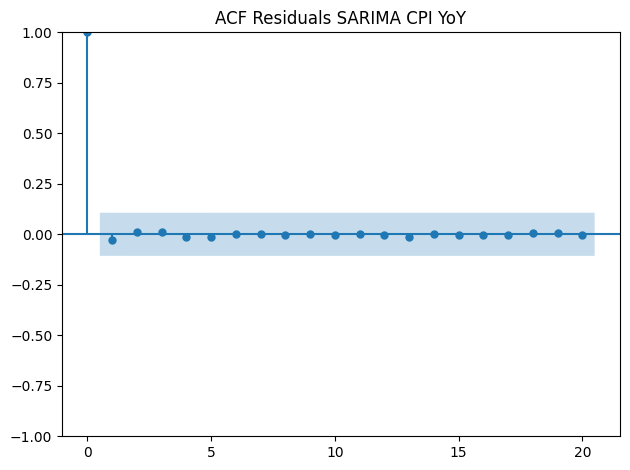

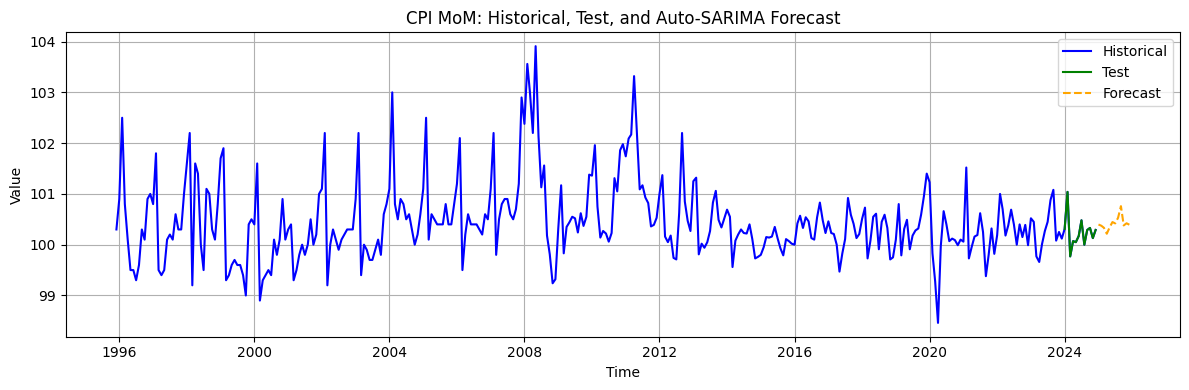

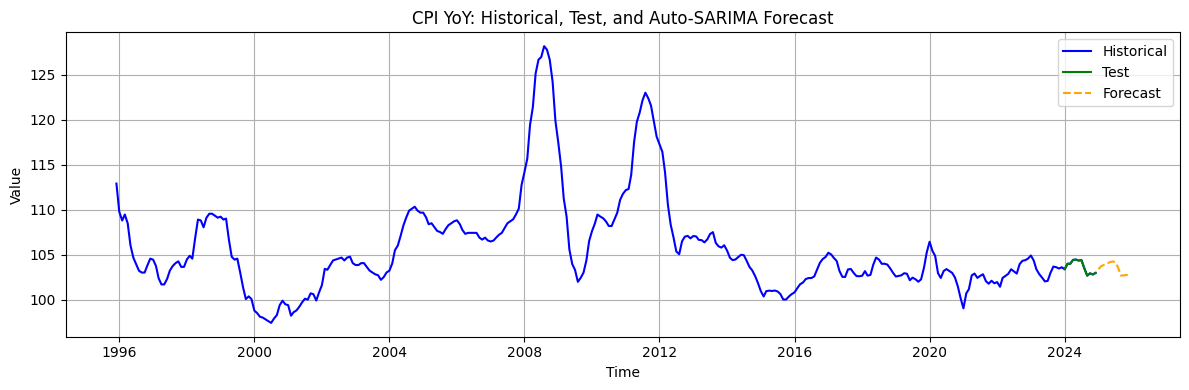

<Figure size 500x300 with 0 Axes>

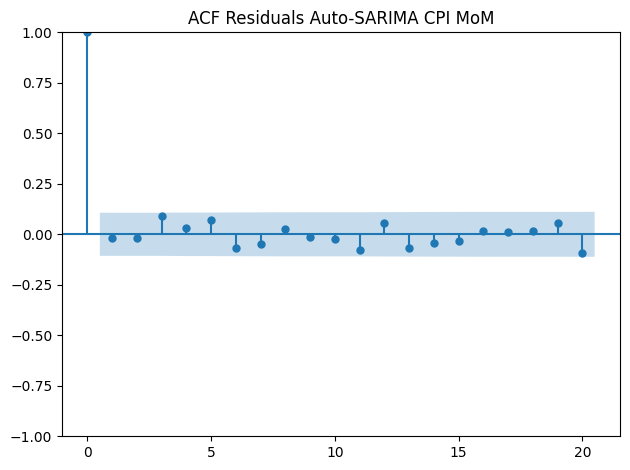

<Figure size 500x300 with 0 Axes>

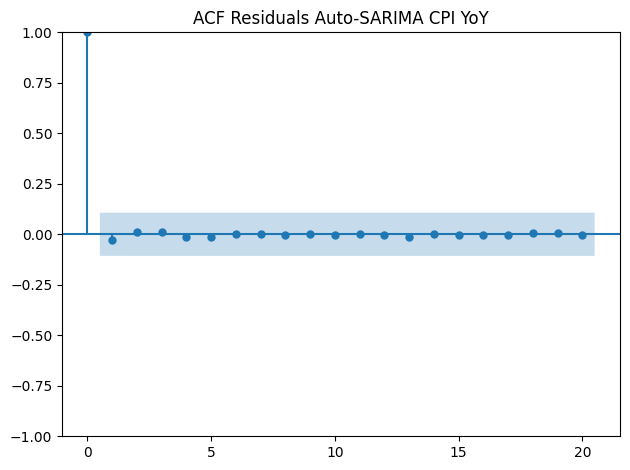

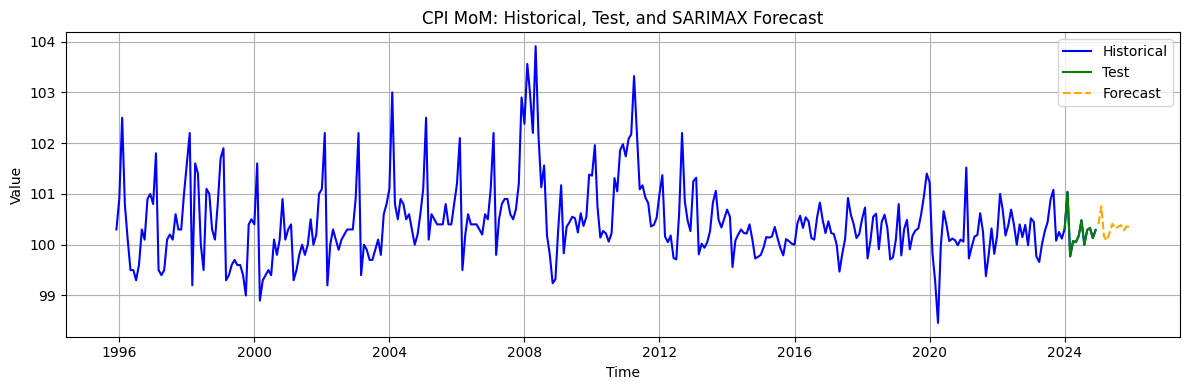

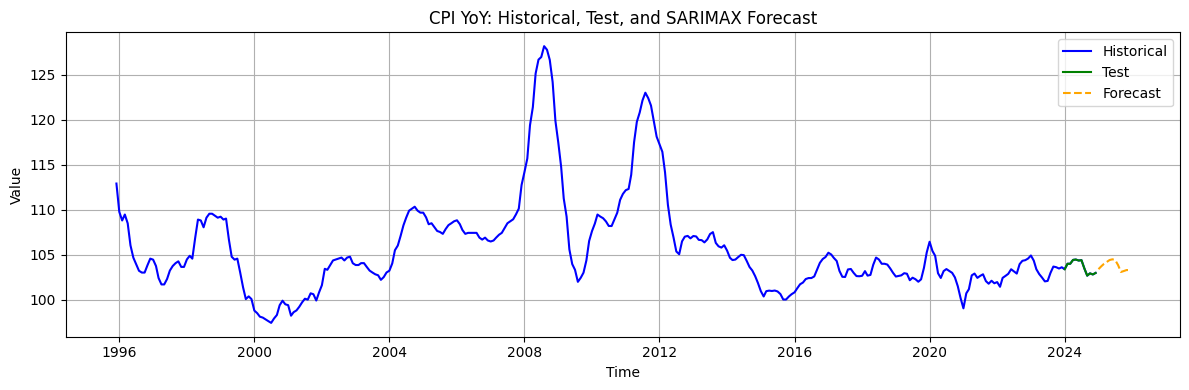

<Figure size 500x300 with 0 Axes>

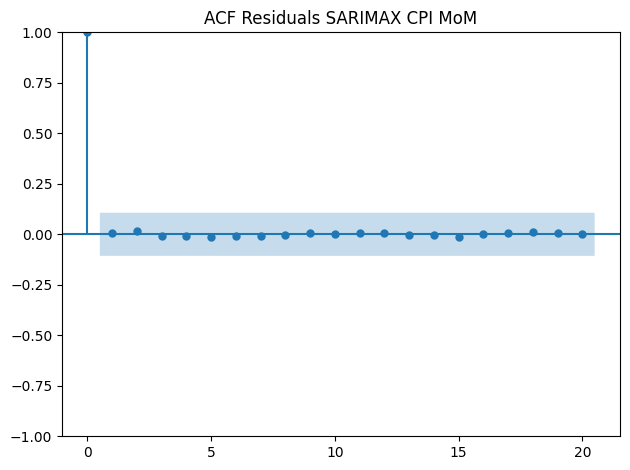

<Figure size 500x300 with 0 Axes>

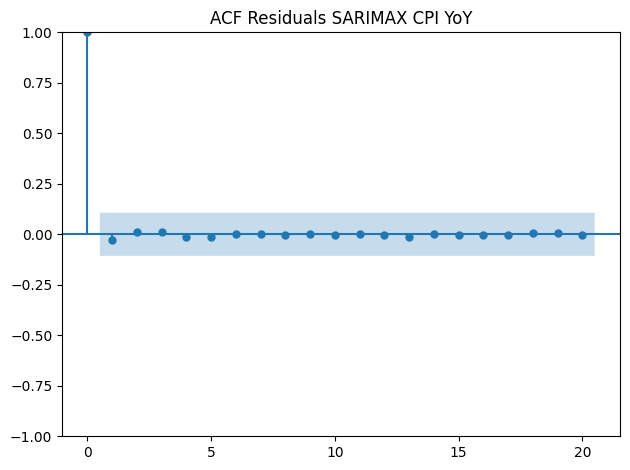

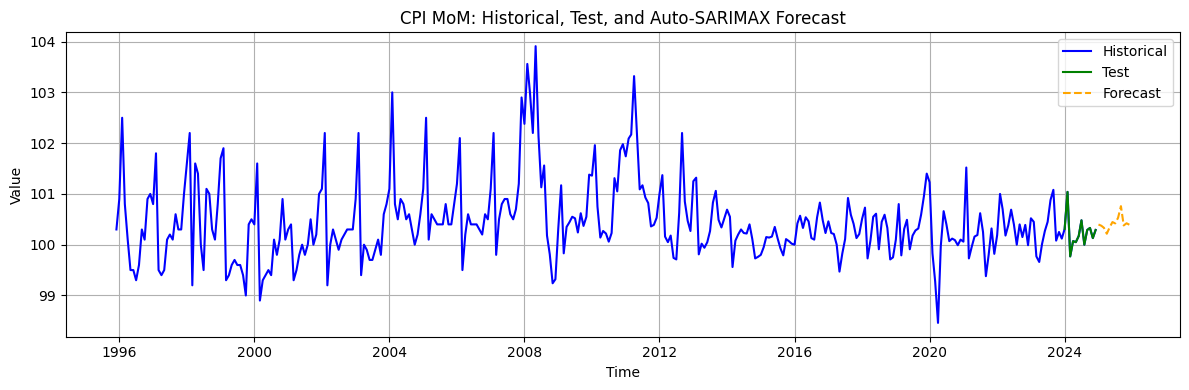

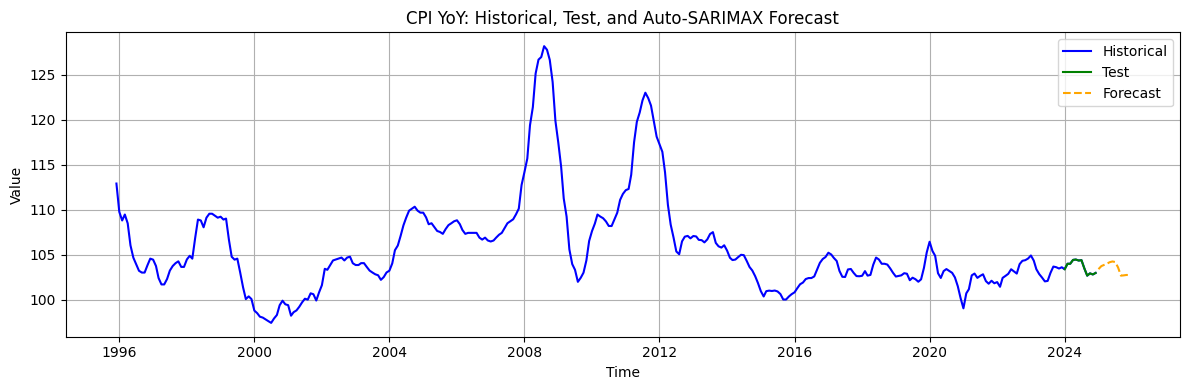

<Figure size 500x300 with 0 Axes>

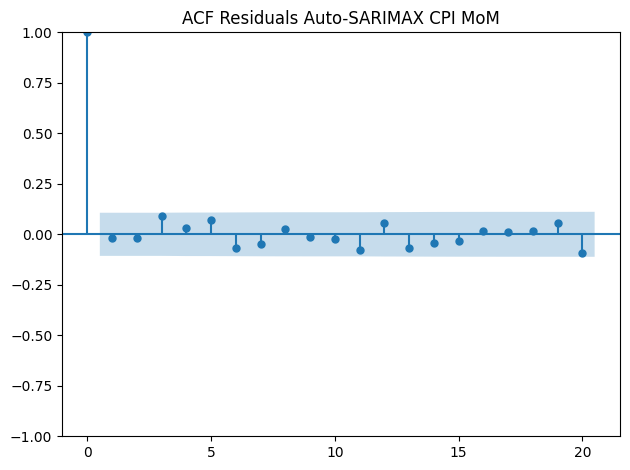

<Figure size 500x300 with 0 Axes>

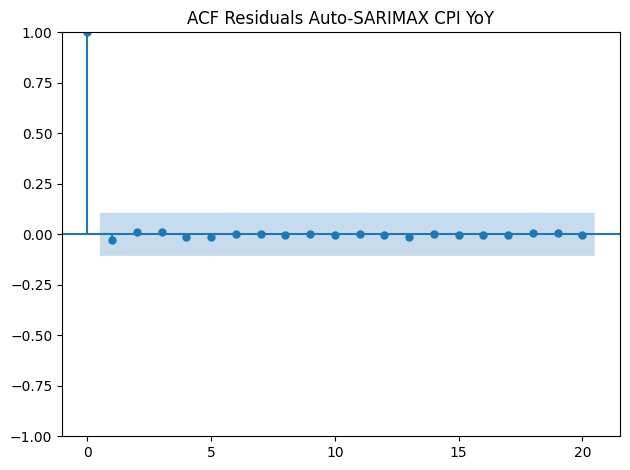

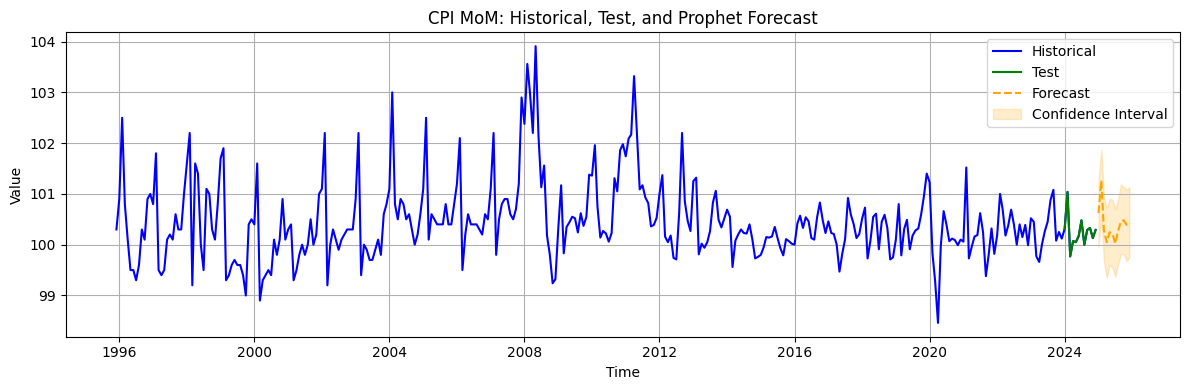

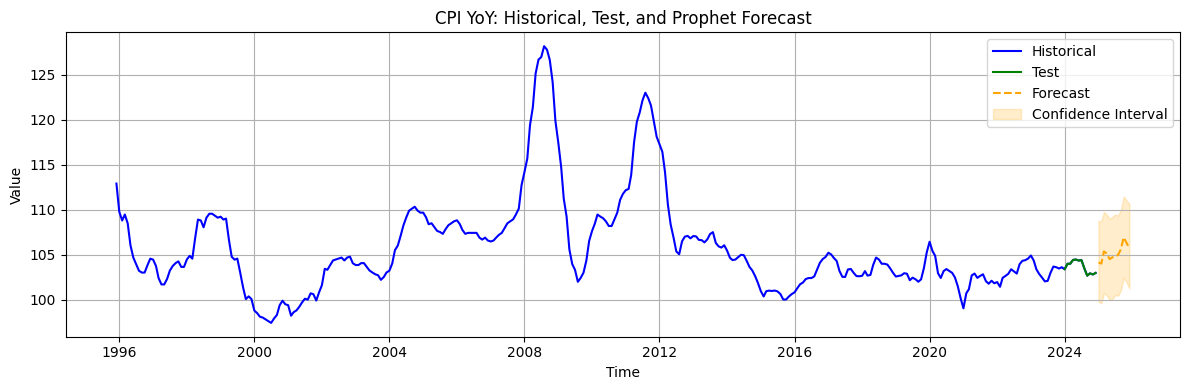

<Figure size 500x300 with 0 Axes>

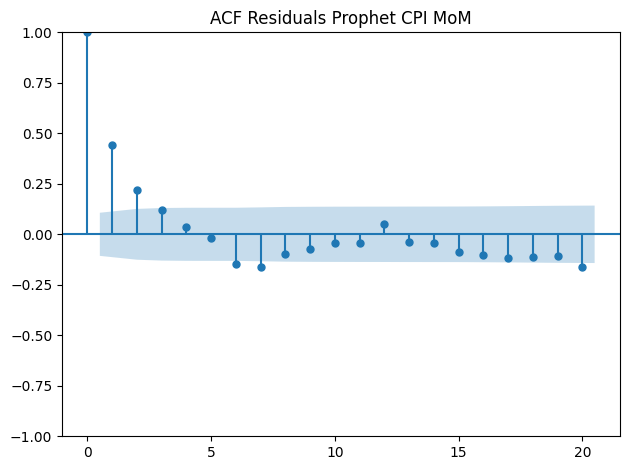

<Figure size 500x300 with 0 Axes>

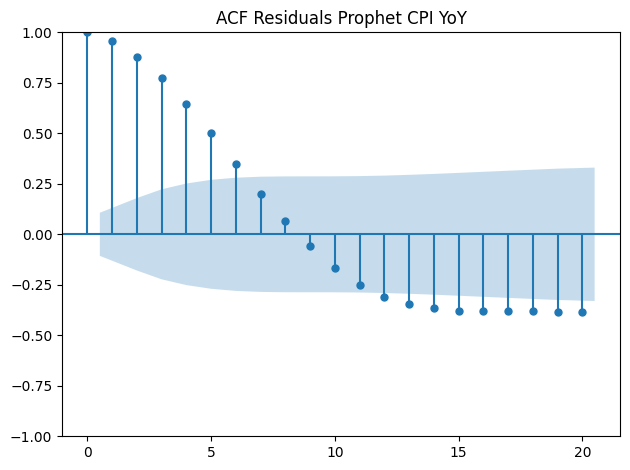

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf
import warnings
import os
warnings.filterwarnings("ignore")

# Hàm tính toán các chỉ số đánh giá
def calculate_metrics(actual, predicted):
    actual = np.where(actual == 0, 1e-6, actual)
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))
    mae = np.mean(np.abs(predicted - actual))
    mape = np.mean(np.abs((predicted - actual) / actual)) * 100
    return rmse, mae, mape

# Hàm trực quan hóa dự báo
def plot_forecast(historical, test, forecast, forecast_index, title, ylabel, filename, confidence_intervals=None):
    plt.figure(figsize=(12, 4))
    plt.plot(historical.index, historical, label='Historical', color='blue')
    plt.plot(test.index, test, label='Test', color='green')
    plt.plot(forecast_index, forecast, label='Forecast', color='orange', linestyle='--')
    if confidence_intervals is not None:
        plt.fill_between(forecast_index, confidence_intervals[0], confidence_intervals[1], 
                         color='orange', alpha=0.2, label='Confidence Interval')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'img/{filename}')
    # plt.close()

# Hàm trực quan hóa ACF phần dư
def plot_residual_acf(residuals, title, filename):
    plt.figure(figsize=(5, 3))
    plot_acf(residuals, lags=20, title=title)
    plt.tight_layout()
    plt.savefig(f'img/{filename}')
    # plt.close()

# Hàm chạy Exponential Smoothing
def run_exponential_smoothing(train, test, forecast_index, seasonal_periods=12, trend=None, seasonal='add'):
    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
    forecast = model.forecast(12)
    rmse, mae, mape = calculate_metrics(test, forecast)
    return forecast, model.resid, rmse, mae, mape

# Hàm chạy SARIMA
def run_sarima(train, test, forecast_index, order, seasonal_order):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order).fit(disp=False)
    forecast = model.forecast(12)
    rmse, mae, mape = calculate_metrics(test, forecast)
    return forecast, model.resid, rmse, mae, mape

# Hàm chạy Auto-SARIMA
def run_auto_sarima(train, test, forecast_index, d, m=12):
    model = pm.auto_arima(
        train, seasonal=True, m=m, start_p=0, start_q=0, max_p=3, max_q=3,
        start_P=0, start_Q=0, max_P=2, max_Q=2, d=d, trace=False,
        error_action='ignore', suppress_warnings=True, stepwise=True
    )
    forecast = model.predict(n_periods=12)
    rmse, mae, mape = calculate_metrics(test, forecast)
    return forecast, model.resid(), rmse, mae, mape

# Hàm chạy SARIMAX
def run_sarimax(train, test, exog_train, exog_test, forecast_index, order, seasonal_order):
    # Kiểm tra kiểu dữ liệu của exog_train và exog_test
    if not all(exog_train.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        raise ValueError("exog_train chứa cột không phải kiểu số!")
    if not all(exog_test.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        raise ValueError("exog_test chứa cột không phải kiểu số!")
    
    model = SARIMAX(train, exog=exog_train, order=order, seasonal_order=seasonal_order).fit(disp=False)
    forecast = model.forecast(steps=12, exog=exog_test)
    rmse, mae, mape = calculate_metrics(test, forecast)
    return forecast, model.resid, rmse, mae, mape

# Hàm chạy Auto-SARIMAX
def run_auto_sarimax(train, test, exog_train, exog_test, forecast_index, d, m=12):
    # Kiểm tra kiểu dữ liệu của exog_train và exog_test
    if not all(exog_train.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        raise ValueError("exog_train chứa cột không phải kiểu số!")
    if not all(exog_test.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        raise ValueError("exog_test chứa cột không phải kiểu số!")
    
    model = pm.auto_arima(
        train, exogenous=exog_train, seasonal=True, m=m, start_p=0, start_q=0, max_p=3, max_q=3,
        start_P=0, start_Q=0, max_P=2, max_Q=2, d=d, trace=False,
        error_action='ignore', suppress_warnings=True, stepwise=True
    )
    forecast = model.predict(n_periods=12, exogenous=exog_test)
    rmse, mae, mape = calculate_metrics(test, forecast)
    return forecast, model.resid(), rmse, mae, mape

# Hàm chạy Prophet
def run_prophet(df_prophet, test, df, forecast_index, regressors):
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='additive')
    for reg in regressors:
        model.add_regressor(reg)
    model.fit(df_prophet[:-12])
    
    future = model.make_future_dataframe(periods=12, freq='MS')
    future = future.merge(df[regressors].reset_index(), 
                         left_on='ds', right_on='time', how='left')
    future[regressors] = future[regressors].interpolate()
    
    forecast = model.predict(future)
    forecast_test = forecast.tail(12)['yhat']
    confidence_intervals = (forecast.tail(12)['yhat_lower'], forecast.tail(12)['yhat_upper'])
    
    rmse, mae, mape = calculate_metrics(test, forecast_test)
    train_forecast = model.predict(df_prophet[:-12])['yhat']
    residuals = df_prophet[:-12]['y'] - train_forecast
    return forecast_test, residuals, rmse, mae, mape, confidence_intervals

# Main execution
if __name__ == "__main__":
    # Tạo thư mục img
    if not os.path.exists('img'):
        os.makedirs('img')
    
    # Đọc dữ liệu
    file_path = "data/analyzed_time_series.csv"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} không tồn tại!")
    
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d', errors='coerce')
    
    if df['time'].isna().any():
        print("Cảnh báo: Có giá trị thời gian không hợp lệ!")
        df = df.dropna(subset=['time'])
    
    df = df.sort_values(by='time')
    df.set_index('time', inplace=True)
    
    # Kiểm tra cột cần thiết
    required_columns = ['cpi_mom', 'cpi_yoy', 'oil_price', 'gold_price', 'interest_rate']
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Thiếu một hoặc nhiều cột cần thiết trong dữ liệu!")
    
    # Kiểm tra độ dài dữ liệu
    if len(df) < 24:
        raise ValueError("Dữ liệu quá ngắn, cần ít nhất 24 tháng!")
    
    # Chia tập train/test
    train_mom, test_mom = df['cpi_mom'][:-12], df['cpi_mom'][-12:]
    train_yoy, test_yoy = df['cpi_yoy'][:-12], df['cpi_yoy'][-12:]
    exog_train = df[['oil_price', 'gold_price']][:-12].interpolate(method='linear')
    exog_test = df[['oil_price', 'gold_price']][-12:].interpolate(method='linear')
    
    # Kiểm tra kiểu dữ liệu của exog_train và exog_test
    print("Kiểu dữ liệu của exog_train:\n", exog_train.dtypes)
    print("Kiểu dữ liệu của exog_test:\n", exog_test.dtypes)
    
    # Tạo chỉ mục dự báo
    last_date = df.index[-1].to_period('M').to_timestamp()
    forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')
    
    # Chuẩn bị dữ liệu cho Prophet
    df_prophet_mom = pd.DataFrame({
        'ds': df.index, 
        'y': df['cpi_mom'].clip(lower=1e-6),
        'oil_price': df['oil_price'],
        'gold_price': df['gold_price']
    }).reset_index(drop=True)
    
    df_prophet_yoy = pd.DataFrame({
        'ds': df.index, 
        'y': df['cpi_yoy'].clip(lower=1e-6),
        'oil_price': df['oil_price'],
        'gold_price': df['gold_price']
    }).reset_index(drop=True)
    
    # Danh sách mô hình và tham số
    models = [
        ('Exponential Smoothing', run_exponential_smoothing, {'mom': {'seasonal_periods': 12}, 
                                                             'yoy': {'trend': 'add', 'seasonal_periods': 12}}),
        ('SARIMA', run_sarima, {'mom': {'order': (1, 0, 1), 'seasonal_order': (1, 0, 1, 12)},
                                'yoy': {'order': (1, 1, 1), 'seasonal_order': (1, 0, 1, 12)}}),
        ('Auto-SARIMA', run_auto_sarima, {'mom': {'d': 0}, 'yoy': {'d': 1}}),
        ('SARIMAX', run_sarimax, {'mom': {'order': (1, 0, 1), 'seasonal_order': (1, 0, 1, 12)},
                                  'yoy': {'order': (1, 1, 1), 'seasonal_order': (1, 0, 1, 12)}}),
        ('Auto-SARIMAX', run_auto_sarimax, {'mom': {'d': 0}, 'yoy': {'d': 1}}),
        ('Prophet', run_prophet, {'mom': {'regressors': ['oil_price', 'gold_price']},
                                  'yoy': {'regressors': ['oil_price', 'gold_price']}})
    ]
    
    # Chạy từng mô hình và lưu kết quả
    results = {'mom': {}, 'yoy': {}}
    for model_name, model_func, params in models:
        # ===== CPI MoM =====
        if model_name == 'Prophet':
            forecast, residuals, rmse, mae, mape, *extra = model_func(
                df_prophet_mom, test_mom, df, forecast_index, params['mom']['regressors']
            )
        else:
            if 'SARIMAX' in model_name:
                args = [train_mom, test_mom, exog_train, exog_test, forecast_index]
            else:
                args = [train_mom, test_mom, forecast_index]
            forecast, residuals, rmse, mae, mape, *extra = model_func(*args, **params['mom'])

        # forecast, residuals, rmse, mae, mape, *extra = model_func(*args, **params['mom'])
        results['mom'][model_name] = {
            'forecast': forecast, 'residuals': residuals, 
            'rmse': rmse, 'mae': mae, 'mape': mape
        }
        if extra:
            results['mom'][model_name]['confidence_intervals'] = extra[0]

        # ===== CPI YoY =====
        if model_name == 'Prophet':
            forecast, residuals, rmse, mae, mape, *extra = model_func(
                df_prophet_yoy, test_yoy, df, forecast_index, params['yoy']['regressors']
            )
        else:
            if 'SARIMAX' in model_name:
                args = [train_yoy, test_yoy, exog_train, exog_test, forecast_index]
            else:
                args = [train_yoy, test_yoy, forecast_index]
            forecast, residuals, rmse, mae, mape, *extra = model_func(*args, **params['yoy'])

        # forecast, residuals, rmse, mae, mape, *extra = model_func(*args, **params['yoy'])
        results['yoy'][model_name] = {
            'forecast': forecast, 'residuals': residuals, 
            'rmse': rmse, 'mae': mae, 'mape': mape
        }
        if extra:
            results['yoy'][model_name]['confidence_intervals'] = extra[0]

        # Trực quan hóa dự báo
        plot_forecast(df['cpi_mom'], test_mom, results['mom'][model_name]['forecast'], forecast_index,
                    f'CPI MoM: Historical, Test, and {model_name} Forecast', 'Value',
                    f'cpi_mom_{model_name.lower().replace(" ", "_")}_forecast.png',
                    results['mom'][model_name].get('confidence_intervals'))

        plot_forecast(df['cpi_yoy'], test_yoy, results['yoy'][model_name]['forecast'], forecast_index,
                    f'CPI YoY: Historical, Test, and {model_name} Forecast', 'Value',
                    f'cpi_yoy_{model_name.lower().replace(" ", "_")}_forecast.png',
                    results['yoy'][model_name].get('confidence_intervals'))

        # ACF phần dư
        plot_residual_acf(results['mom'][model_name]['residuals'], f'ACF Residuals {model_name} CPI MoM',
                        f'residual_acf_{model_name.lower().replace(" ", "_")}_mom.png')
        plot_residual_acf(results['yoy'][model_name]['residuals'], f'ACF Residuals {model_name} CPI YoY',
                        f'residual_acf_{model_name.lower().replace(" ", "_")}_yoy.png')
    
    # In kết quả
    for metric in ['rmse', 'mae', 'mape']:
        print(f"\n{metric.upper()} Results:")
        for model_name in results['mom']:
            print(f"{model_name} CPI MoM: {results['mom'][model_name][metric]:.4f}")
            print(f"{model_name} CPI YoY: {results['yoy'][model_name][metric]:.4f}")

Kiểu dữ liệu của exog_train:
 oil_price     float64
gold_price    float64
dtype: object
Kiểu dữ liệu của exog_test:
 oil_price     float64
gold_price    float64
dtype: object


02:23:10 - cmdstanpy - INFO - Chain [1] start processing
02:23:11 - cmdstanpy - INFO - Chain [1] done processing
02:23:11 - cmdstanpy - INFO - Chain [1] start processing
02:23:11 - cmdstanpy - INFO - Chain [1] done processing



RMSE Results:
Exponential Smoothing CPI MoM: 0.2461
Exponential Smoothing CPI YoY: 1.1998
SARIMA CPI MoM: 0.1900
SARIMA CPI YoY: 0.2592
Auto-SARIMA CPI MoM: 0.3599
Auto-SARIMA CPI YoY: 0.2111
SARIMAX CPI MoM: 0.2165
SARIMAX CPI YoY: 0.2677
Auto-SARIMAX CPI MoM: 0.3599
Auto-SARIMAX CPI YoY: 0.2111
Prophet CPI MoM: nan
Prophet CPI YoY: nan

MAE Results:
Exponential Smoothing CPI MoM: 0.2036
Exponential Smoothing CPI YoY: 0.8875
SARIMA CPI MoM: 0.1733
SARIMA CPI YoY: 0.2136
Auto-SARIMA CPI MoM: 0.2944
Auto-SARIMA CPI YoY: 0.1719
SARIMAX CPI MoM: 0.1805
SARIMAX CPI YoY: 0.2142
Auto-SARIMAX CPI MoM: 0.2944
Auto-SARIMAX CPI YoY: 0.1719
Prophet CPI MoM: nan
Prophet CPI YoY: nan

MAPE Results:
Exponential Smoothing CPI MoM: 0.2032
Exponential Smoothing CPI YoY: 0.8608
SARIMA CPI MoM: 0.1728
SARIMA CPI YoY: 0.2067
Auto-SARIMA CPI MoM: 0.2937
Auto-SARIMA CPI YoY: 0.1655
SARIMAX CPI MoM: 0.1801
SARIMAX CPI YoY: 0.2074
Auto-SARIMAX CPI MoM: 0.2937
Auto-SARIMAX CPI YoY: 0.1655
Prophet CPI MoM: nan

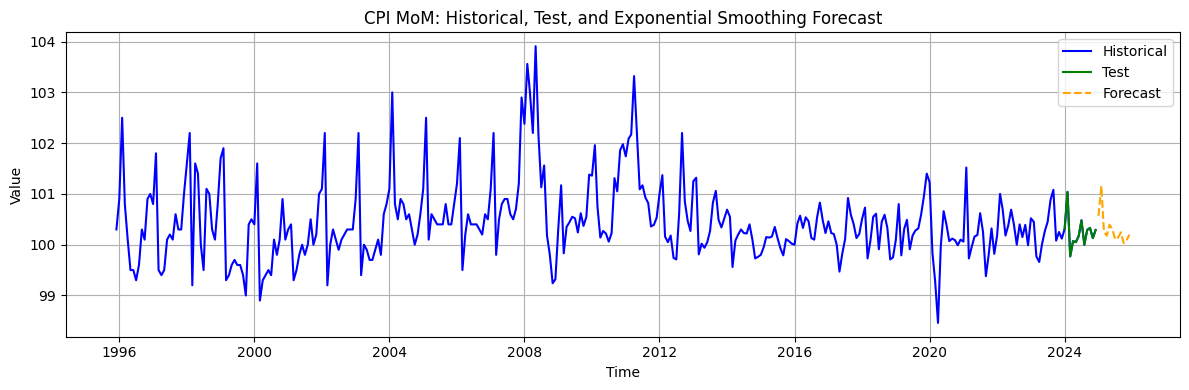

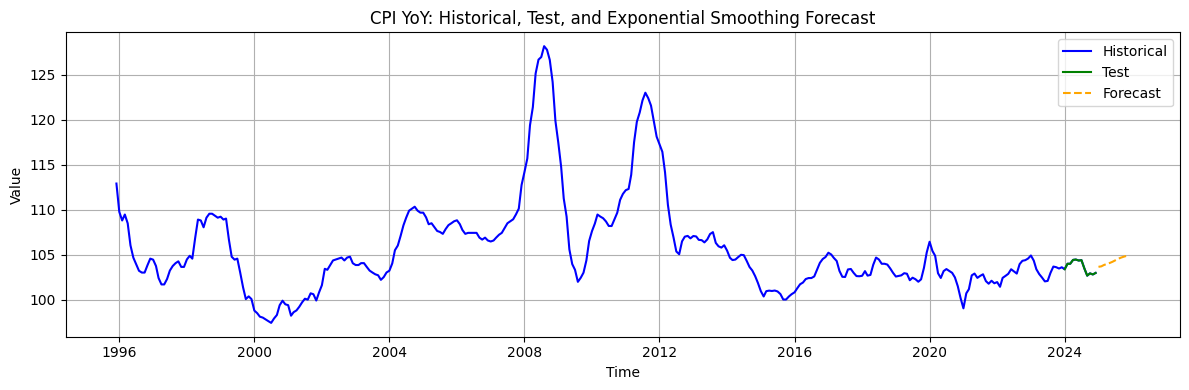

<Figure size 500x300 with 0 Axes>

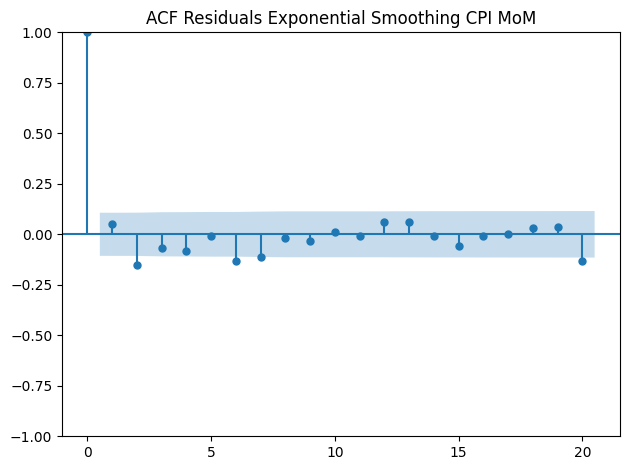

<Figure size 500x300 with 0 Axes>

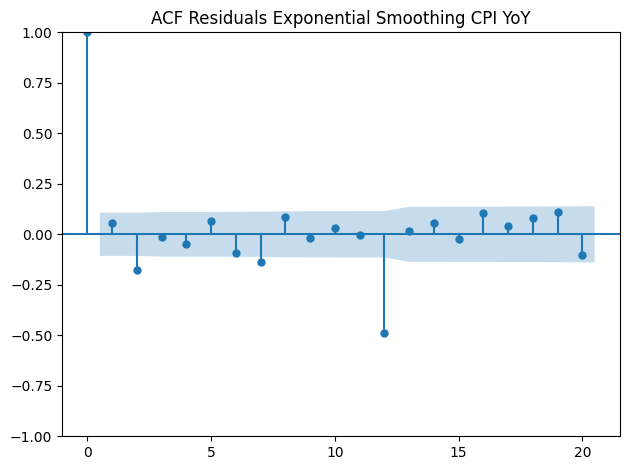

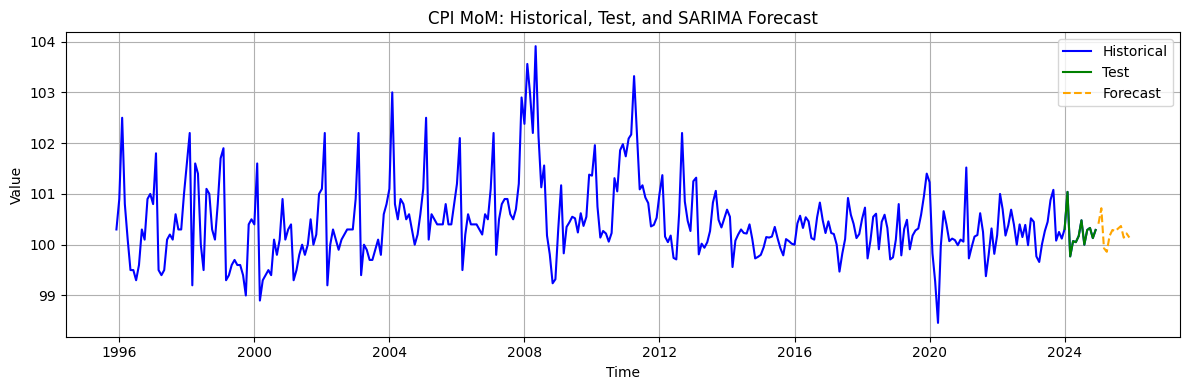

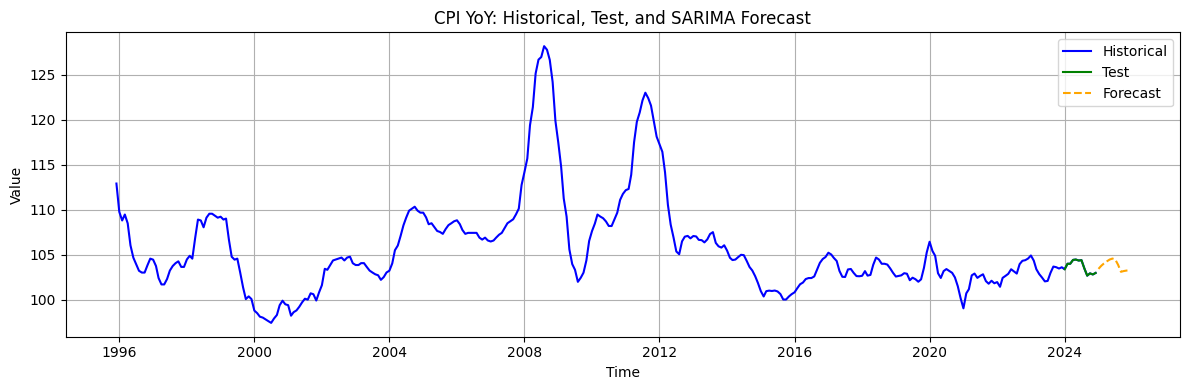

<Figure size 500x300 with 0 Axes>

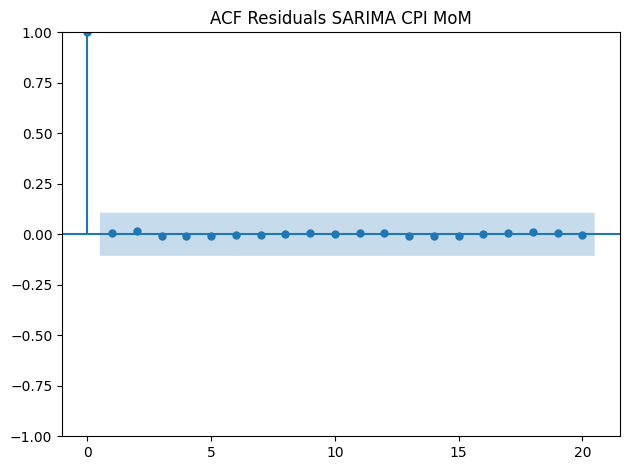

<Figure size 500x300 with 0 Axes>

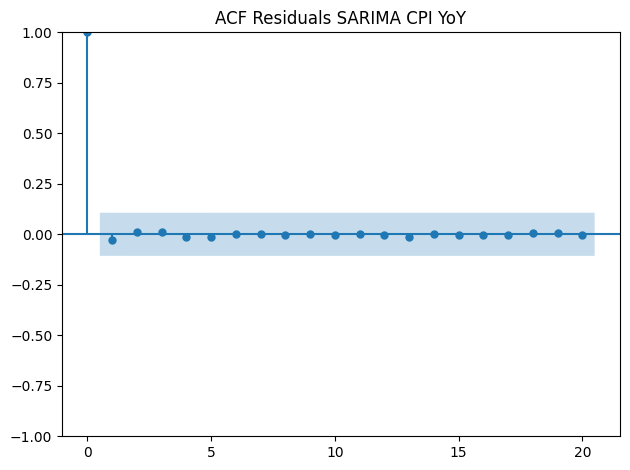

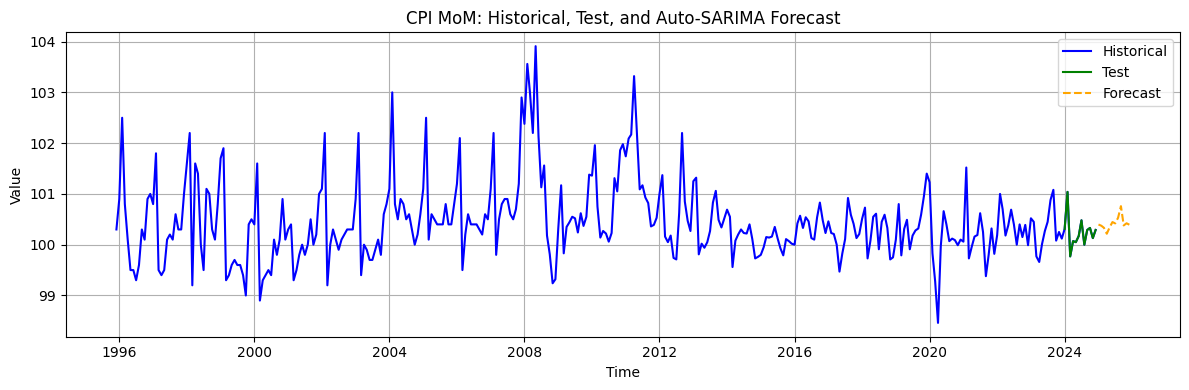

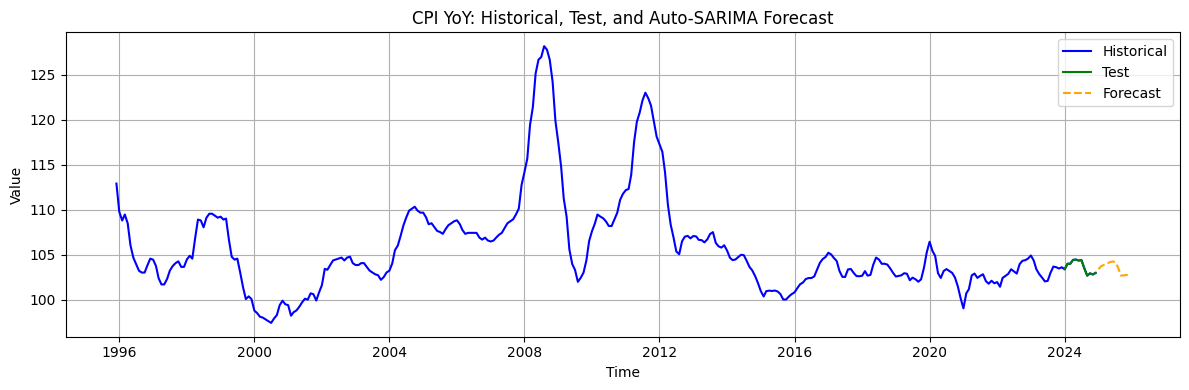

<Figure size 500x300 with 0 Axes>

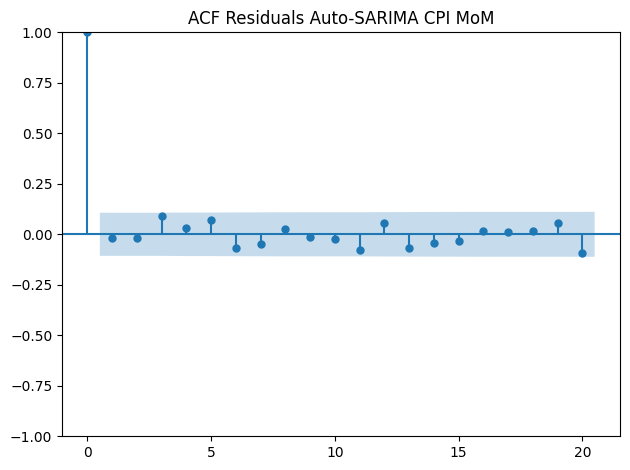

<Figure size 500x300 with 0 Axes>

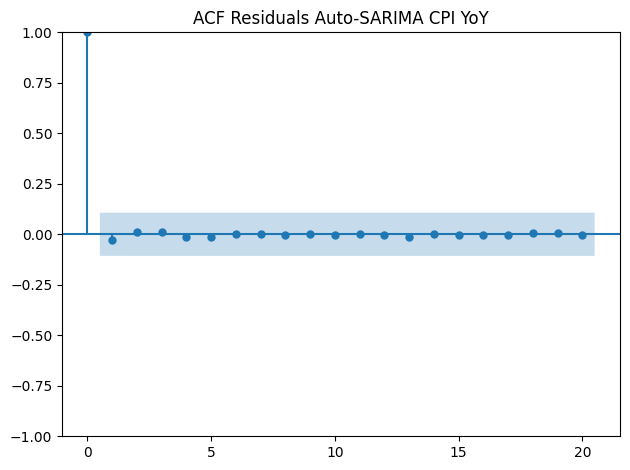

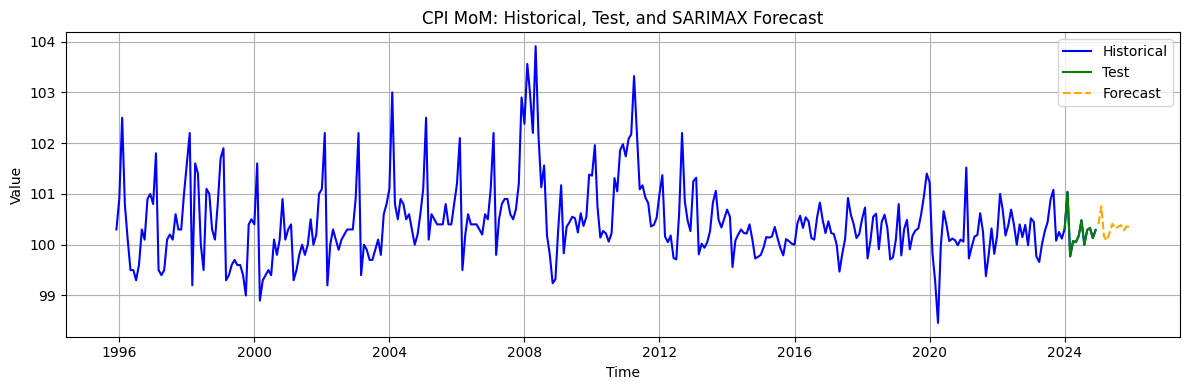

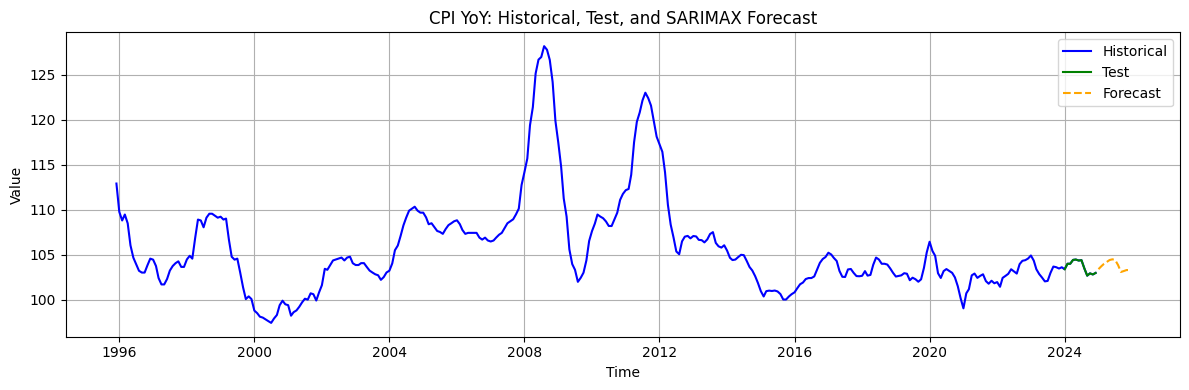

<Figure size 500x300 with 0 Axes>

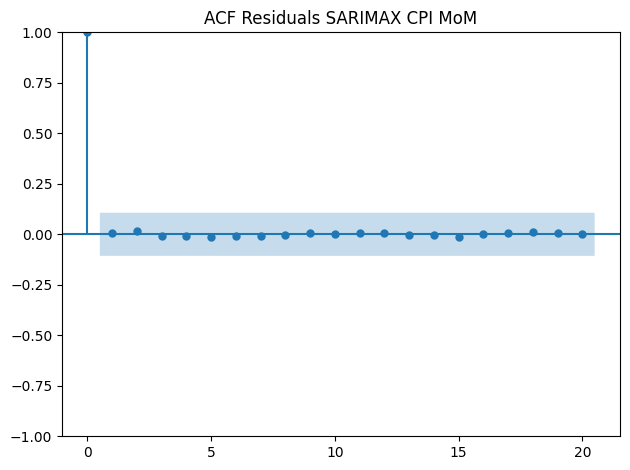

<Figure size 500x300 with 0 Axes>

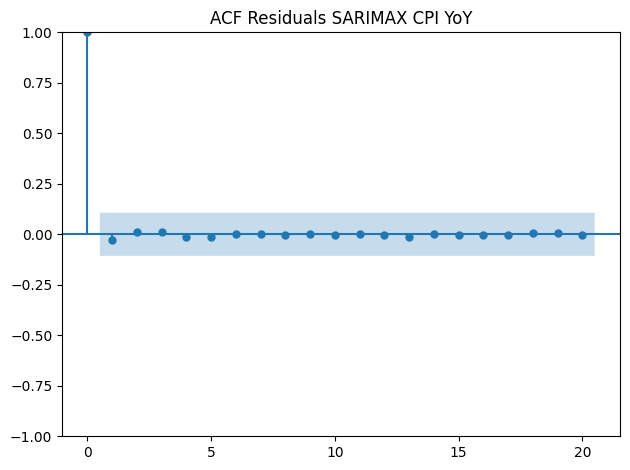

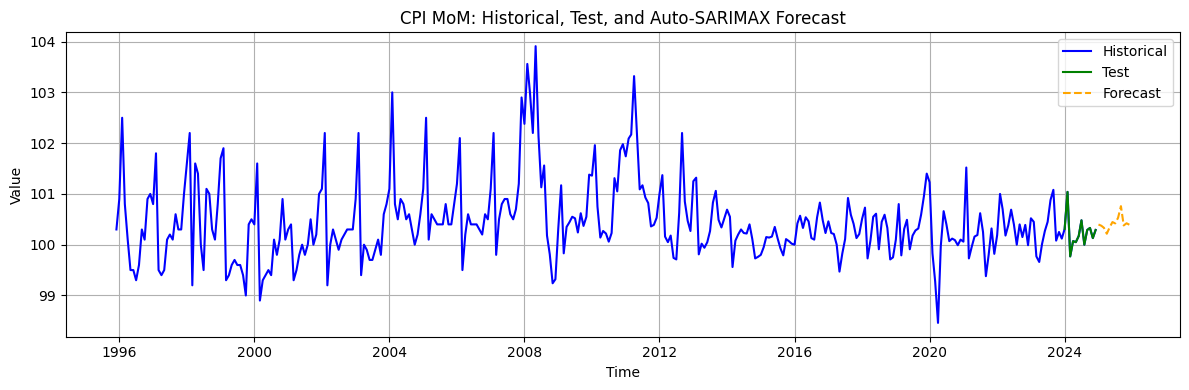

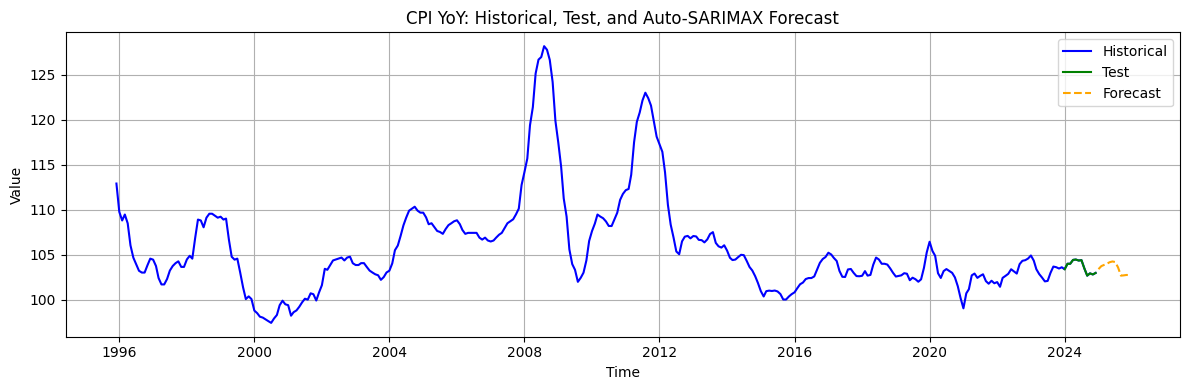

<Figure size 500x300 with 0 Axes>

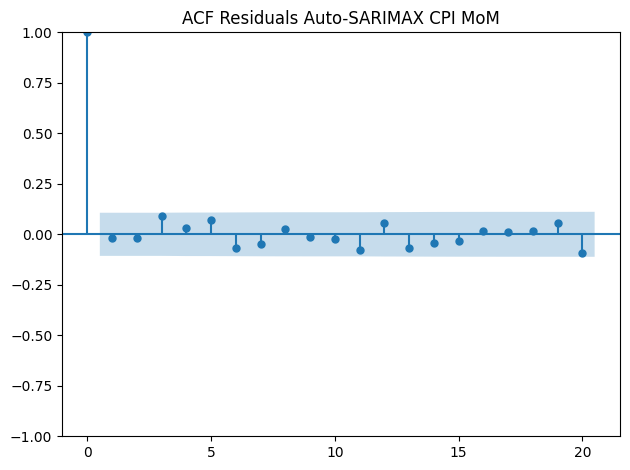

<Figure size 500x300 with 0 Axes>

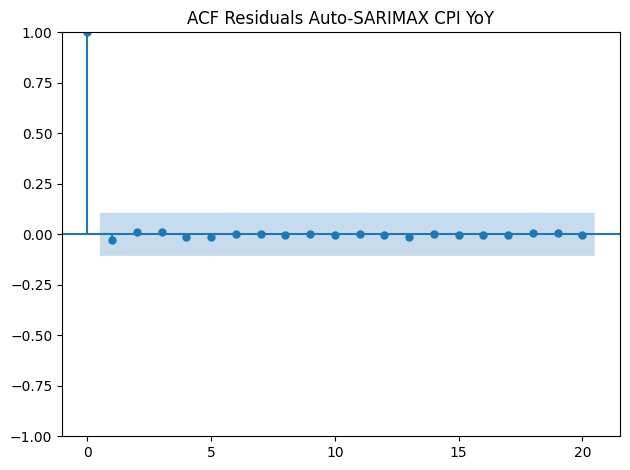

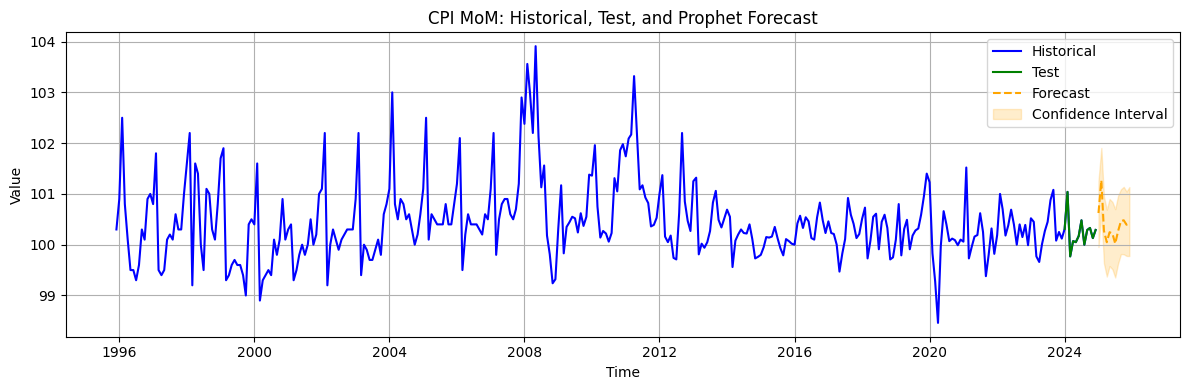

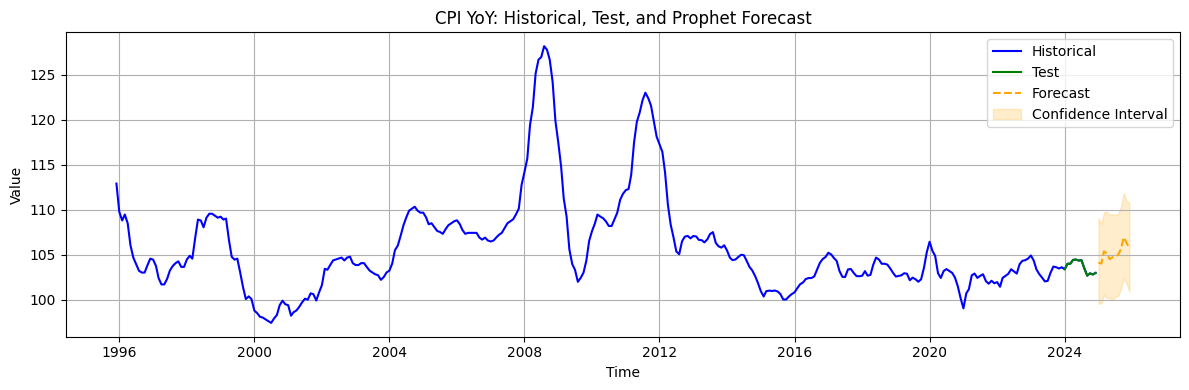

<Figure size 500x300 with 0 Axes>

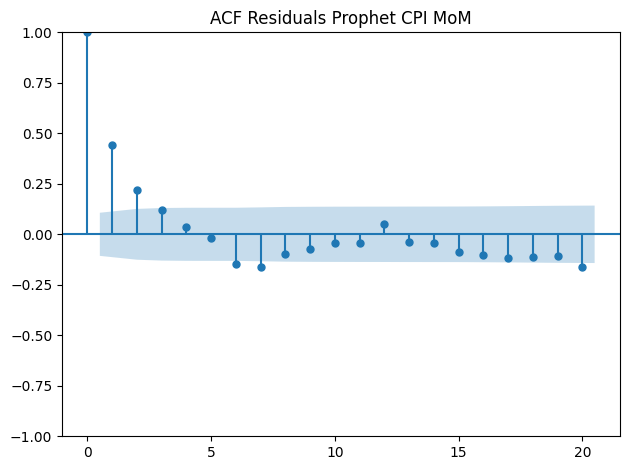

<Figure size 500x300 with 0 Axes>

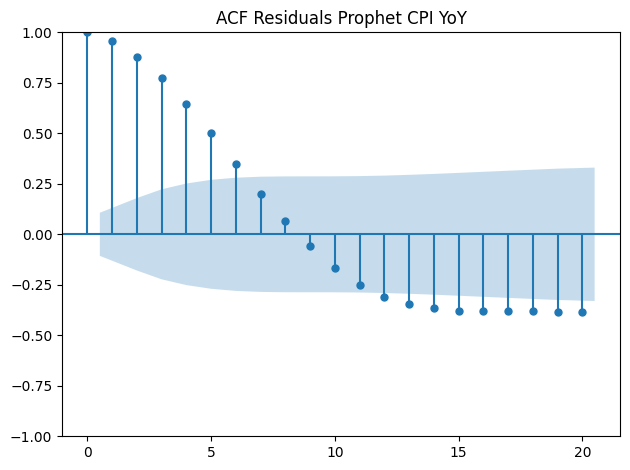

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf
from itertools import product
import warnings
import os
warnings.filterwarnings("ignore")

# Hàm tính toán các chỉ số đánh giá
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(((predicted - actual) ** 2).mean())
    mae = np.mean(np.abs(predicted - actual))
    mape = np.mean(np.abs((predicted - actual) / actual)) * 100
    return rmse, mae, mape

# Hàm trực quan hóa dự báo
def plot_forecast(historical, test, forecast, forecast_index, title, ylabel, filename, confidence_intervals=None):
    plt.figure(figsize=(12, 4))
    plt.plot(historical.index, historical, label='Historical', color='blue')
    plt.plot(test.index, test, label='Test', color='green')
    plt.plot(forecast_index, forecast, label='Forecast', color='orange', linestyle='--')
    if confidence_intervals is not None:
        plt.fill_between(forecast_index, confidence_intervals[0], confidence_intervals[1], 
                         color='orange', alpha=0.2, label='Confidence Interval')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'img/{filename}')
    # plt.close()

# Hàm trực quan hóa ACF phần dư
def plot_residual_acf(residuals, title, filename):
    plt.figure(figsize=(5, 3))
    plot_acf(residuals, lags=20, title=title)
    plt.tight_layout()
    plt.savefig(f'img/{filename}')
    # plt.close()

# Hàm chạy Exponential Smoothing
def run_exponential_smoothing(train, test, forecast_index, seasonal_periods=12, trend=None, seasonal='add'):
    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
    forecast = model.forecast(12)
    rmse, mae, mape = calculate_metrics(test, forecast)
    return forecast, model.resid, rmse, mae, mape

# Hàm chạy SARIMA
def run_sarima(train, test, forecast_index, order, seasonal_order):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order).fit(disp=False)
    forecast = model.forecast(12)
    rmse, mae, mape = calculate_metrics(test, forecast)
    return forecast, model.resid, rmse, mae, mape

# Hàm chạy Auto-SARIMA
def run_auto_sarima(train, test, forecast_index, d, m=12):
    model = pm.auto_arima(
        train, seasonal=True, m=m, start_p=0, start_q=0, max_p=3, max_q=3,
        start_P=0, start_Q=0, max_P=2, max_Q=2, d=d, trace=False,
        error_action='ignore', suppress_warnings=True, stepwise=True
    )
    forecast = model.predict(n_periods=12)
    rmse, mae, mape = calculate_metrics(test, forecast)
    return forecast, model.resid(), rmse, mae, mape

# Hàm chạy SARIMAX
def run_sarimax(train, test, exog_train, exog_test, forecast_index, order, seasonal_order):
    if not isinstance(exog_train, pd.DataFrame) or not isinstance(exog_test, pd.DataFrame):
        raise ValueError("exog_train và exog_test phải là pandas.DataFrame!")
    if not all(exog_train.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        raise ValueError("exog_train chứa cột không phải kiểu số!")
    if not all(exog_test.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        raise ValueError("exog_test chứa cột không phải kiểu số!")
    
    model = SARIMAX(train, exog=exog_train, order=order, seasonal_order=seasonal_order).fit(disp=False)
    forecast = model.forecast(steps=12, exog=exog_test)
    rmse, mae, mape = calculate_metrics(test, forecast)
    return forecast, model.resid, rmse, mae, mape

# Hàm chạy Auto-SARIMAX
def run_auto_sarimax(train, test, exog_train, exog_test, forecast_index, d, m=12):
    if not isinstance(exog_train, pd.DataFrame) or not isinstance(exog_test, pd.DataFrame):
        raise ValueError("exog_train và exog_test phải là pandas.DataFrame!")
    if not all(exog_train.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        raise ValueError("exog_train chứa cột không phải kiểu số!")
    if not all(exog_test.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        raise ValueError("exog_test chứa cột không phải kiểu số!")
    
    model = pm.auto_arima(
        train, exogenous=exog_train, seasonal=True, m=m, start_p=0, start_q=0, max_p=3, max_q=3,
        start_P=0, start_Q=0, max_P=2, max_Q=2, d=d, trace=False,
        error_action='ignore', suppress_warnings=True, stepwise=True
    )
    forecast = model.predict(n_periods=12, exogenous=exog_test)
    rmse, mae, mape = calculate_metrics(test, forecast)
    return forecast, model.resid(), rmse, mae, mape

# Hàm tối ưu tham số cho Prophet
def optimize_prophet_params(df_prophet, test, df, forecast_index, regressors, param_grid):
    best_rmse = float('inf')
    best_params = None
    best_forecast = None
    best_residuals = None
    best_confidence_intervals = None
    
    # Tạo tổ hợp tham số
    param_combinations = list(product(
        param_grid['changepoint_prior_scale'],
        param_grid['seasonality_prior_scale'],
        param_grid['holidays_prior_scale'],
        param_grid['seasonality_mode']
    ))
    
    print(f"Tổng số tổ hợp tham số Prophet: {len(param_combinations)}")
    
    for cp_scale, s_scale, h_scale, s_mode in param_combinations:
        try:
            model = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=cp_scale,
                seasonality_prior_scale=s_scale,
                holidays_prior_scale=h_scale,
                seasonality_mode=s_mode
            )
            for reg in regressors:
                model.add_regressor(reg)
            model.fit(df_prophet[:-12])
            
            future = model.make_future_dataframe(periods=12, freq='MS')
            future = future.merge(df[regressors].reset_index(), 
                                 left_on='ds', right_on='time', how='left')
            future[regressors] = future[regressors].interpolate()
            
            forecast = model.predict(future)
            forecast_test = forecast.tail(12)['yhat']
            rmse, _, _ = calculate_metrics(test, forecast_test)
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {
                    'changepoint_prior_scale': cp_scale,
                    'seasonality_prior_scale': s_scale,
                    'holidays_prior_scale': h_scale,
                    'seasonality_mode': s_mode
                }
                best_forecast = forecast_test
                best_residuals = df_prophet[:-12]['y'] - model.predict(df_prophet[:-12])['yhat']
                best_confidence_intervals = (forecast.tail(12)['yhat_lower'], forecast.tail(12)['yhat_upper'])
                
                print(f"RMSE tốt hơn: {best_rmse:.4f} với tham số: {best_params}")
        
        except Exception as e:
            print(f"Lỗi với tham số {cp_scale}, {s_scale}, {h_scale}, {s_mode}: {str(e)}")
            continue
    
    if best_params is None:
        raise ValueError("Không tìm được tham số tối ưu cho Prophet!")
    
    return best_forecast, best_residuals, best_rmse, *calculate_metrics(test, best_forecast), best_confidence_intervals, best_params

# Hàm chạy Prophet
def run_prophet(df_prophet, test, df, forecast_index, regressors, optimize=False, param_grid=None):
    if optimize and param_grid:
        print("Tối ưu tham số cho Prophet...")
        forecast, residuals, rmse, mae, mape, confidence_intervals, best_params = optimize_prophet_params(
            df_prophet, test, df, forecast_index, regressors, param_grid
        )
        print(f"Tham số tốt nhất: {best_params}")
        return forecast, residuals, rmse, mae, mape, confidence_intervals
    else:
        model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='additive')
        for reg in regressors:
            model.add_regressor(reg)
        model.fit(df_prophet[:-12])
        
        future = model.make_future_dataframe(periods=12, freq='MS')
        future = future.merge(df[regressors].reset_index(), 
                             left_on='ds', right_on='time', how='left')
        future[regressors] = future[regressors].interpolate()
        
        forecast = model.predict(future)
        forecast_test = forecast.tail(12)['yhat']
        confidence_intervals = (forecast.tail(12)['yhat_lower'], forecast.tail(12)['yhat_upper'])
        
        rmse, mae, mape = calculate_metrics(test, forecast_test)
        train_forecast = model.predict(df_prophet[:-12])['yhat']
        residuals = df_prophet[:-12]['y'] - train_forecast
        return forecast_test, residuals, rmse, mae, mape, confidence_intervals

# Main execution
if __name__ == "__main__":
    # Tạo thư mục img
    if not os.path.exists('img'):
        os.makedirs('img')
    
    # Đọc dữ liệu
    file_path = "data/analyzed_time_series.csv"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} không tồn tại!")
    
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d', errors='coerce')
    
    if df['time'].isna().any():
        print("Cảnh báo: Có giá trị thời gian không hợp lệ!")
        df = df.dropna(subset=['time'])
    
    df = df.sort_values(by='time')
    df.set_index('time', inplace=True)
    
    # Kiểm tra cột cần thiết
    required_columns = ['cpi_mom', 'cpi_yoy', 'oil_price', 'gold_price', 'interest_rate']
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Thiếu một hoặc nhiều cột cần thiết trong dữ liệu!")
    
    # Kiểm tra độ dài dữ liệu
    if len(df) < 24:
        raise ValueError("Dữ liệu quá ngắn, cần ít nhất 24 tháng!")
    
    # Chia tập train/test
    train_mom, test_mom = df['cpi_mom'][:-12], df['cpi_mom'][-12:]
    train_yoy, test_yoy = df['cpi_yoy'][:-12], df['cpi_yoy'][-12:]
    exog_train = df[['oil_price', 'gold_price']][:-12].interpolate(method='linear')
    exog_test = df[['oil_price', 'gold_price']][-12:].interpolate(method='linear')
    
    # Kiểm tra dữ liệu ngoại sinh
    print("Kiểu dữ liệu của exog_train:\n", exog_train.dtypes)
    print("Kiểu dữ liệu của exog_test:\n", exog_test.dtypes)
    
    # Tạo chỉ mục dự báo
    last_date = df.index[-1].to_period('M').to_timestamp()
    forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')
    
    # Chuẩn bị dữ liệu cho Prophet
    df_prophet_mom = pd.DataFrame({
        'ds': df.index, 
        'y': df['cpi_mom'].clip(lower=1e-6),
        'oil_price': df['oil_price'],
        'gold_price': df['gold_price']
    }).reset_index(drop=True)
    
    df_prophet_yoy = pd.DataFrame({
        'ds': df.index, 
        'y': df['cpi_yoy'].clip(lower=1e-6),
        'oil_price': df['oil_price'],
        'gold_price': df['gold_price']
    }).reset_index(drop=True)
    
    # Định nghĩa lưới tham số cho Prophet
    prophet_param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.1, 1.0, 10.0],
        'holidays_prior_scale': [0.1, 1.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative']
    }
    
    # Danh sách mô hình và tham số
    models = [
        ('Exponential Smoothing', run_exponential_smoothing, {'mom': {'seasonal_periods': 12}, 
                                                             'yoy': {'trend': 'add', 'seasonal_periods': 12}}),
        ('SARIMA', run_sarima, {'mom': {'order': (1, 0, 1), 'seasonal_order': (1, 0, 1, 12)},
                                'yoy': {'order': (1, 1, 1), 'seasonal_order': (1, 0, 1, 12)}}),
        ('Auto-SARIMA', run_auto_sarima, {'mom': {'d': 0}, 'yoy': {'d': 1}}),
        ('SARIMAX', run_sarimax, {'mom': {'order': (1, 0, 1), 'seasonal_order': (1, 0, 1, 12)},
                                  'yoy': {'order': (1, 1, 1), 'seasonal_order': (1, 0, 1, 12)}}),
        ('Auto-SARIMAX', run_auto_sarimax, {'mom': {'d': 0}, 'yoy': {'d': 1}}),
        ('Prophet', run_prophet, {'mom': {'regressors': ['oil_price', 'gold_price'], 
                                         'optimize': True, 
                                         'param_grid': prophet_param_grid},
                                  'yoy': {'regressors': ['oil_price', 'gold_price'], 
                                          'optimize': True, 
                                          'param_grid': prophet_param_grid}})
    ]
    
    # Chạy từng mô hình và lưu kết quả
    results = {'mom': {}, 'yoy': {}}
    for model_name, model_func, params in models:
        # ===== CPI MoM =====
        if model_name == 'Prophet':
            forecast, residuals, rmse, mae, mape, *extra = model_func(
                df_prophet_mom, test_mom, df, forecast_index, params['mom']['regressors']
            )
        else:
            if 'SARIMAX' in model_name:
                args = [train_mom, test_mom, exog_train, exog_test, forecast_index]
            else:
                args = [train_mom, test_mom, forecast_index]
            forecast, residuals, rmse, mae, mape, *extra = model_func(*args, **params['mom'])

        # forecast, residuals, rmse, mae, mape, *extra = model_func(*args, **params['mom'])
        results['mom'][model_name] = {
            'forecast': forecast, 'residuals': residuals, 
            'rmse': rmse, 'mae': mae, 'mape': mape
        }
        if extra:
            results['mom'][model_name]['confidence_intervals'] = extra[0]

        # ===== CPI YoY =====
        if model_name == 'Prophet':
            forecast, residuals, rmse, mae, mape, *extra = model_func(
                df_prophet_yoy, test_yoy, df, forecast_index, params['yoy']['regressors']
            )
        else:
            if 'SARIMAX' in model_name:
                args = [train_yoy, test_yoy, exog_train, exog_test, forecast_index]
            else:
                args = [train_yoy, test_yoy, forecast_index]
            forecast, residuals, rmse, mae, mape, *extra = model_func(*args, **params['yoy'])

        # forecast, residuals, rmse, mae, mape, *extra = model_func(*args, **params['yoy'])SS
        results['yoy'][model_name] = {'forecast': forecast, 'residuals': residuals, 
                                     'rmse': rmse, 'mae': mae, 'mape': mape}
        if extra:
            results['yoy'][model_name]['confidence_intervals'] = extra[0]
        
        # Trực quan hóa
        plot_forecast(df['cpi_mom'], test_mom, results['mom'][model_name]['forecast'], forecast_index,
                      f'CPI MoM: Historical, Test, and {model_name} Forecast', 'Value',
                      f'cpi_mom_{model_name.lower().replace(" ", "_")}_forecast.png',
                      results['mom'][model_name].get('confidence_intervals'))
        plot_forecast(df['cpi_yoy'], test_yoy, results['yoy'][model_name]['forecast'], forecast_index,
                      f'CPI YoY: Historical, Test, and {model_name} Forecast', 'Value',
                      f'cpi_yoy_{model_name.lower().replace(" ", "_")}_forecast.png',
                      results['yoy'][model_name].get('confidence_intervals'))
        
        # ACF phần dư
        plot_residual_acf(results['mom'][model_name]['residuals'], f'ACF Residuals {model_name} CPI MoM',
                          f'residual_acf_{model_name.lower().replace(" ", "_")}_mom.png')
        plot_residual_acf(results['yoy'][model_name]['residuals'], f'ACF Residuals {model_name} CPI YoY',
                          f'residual_acf_{model_name.lower().replace(" ", "_")}_yoy.png')
    
    # In kết quả
    for metric in ['rmse', 'mae', 'mape']:
        print(f"\n{metric.upper()} Results:")
        for model_name in results['mom']:
            print(f"{model_name} CPI MoM: {results['mom'][model_name][metric]:.4f}")
            print(f"{model_name} CPI YoY: {results['yoy'][model_name][metric]:.4f}")